### Exploratory Data Analysis

- Since this data only have 832 MB for content, 4.9 MB for correlations.csv and 14 MB for topic.csv so it's totally OK to use pandas here

In [1]:
!ls -alh ./data/

total 850M
drwxrwxrwx 1 root root 4.0K  2月  2 21:38 .
drwxrwxrwx 1 root root 4.0K  2月  4 23:21 ..
-rwxrwxrwx 1 root root 832M 12月 14 19:43 content.csv
-rwxrwxrwx 1 root root 4.9M 12月 14 19:44 correlations.csv
-rwxrwxrwx 1 root root  336 12月 14 19:44 sample_submission.csv
-rwxrwxrwx 1 root root  14M 12月 14 19:44 topics.csv


### Loading liberary

In [85]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

%matplotlib inline


In [78]:
%%time
# loading data
contents = pd.read_csv('./data/content.csv')
topics = pd.read_csv('./data/topics.csv')
correlations = pd.read_csv('./data/correlations.csv')
sample_sub = pd.read_csv('./data/sample_submission.csv')

CPU times: user 4.2 s, sys: 377 ms, total: 4.58 s
Wall time: 4.58 s


## Content
Contains a row for each content item in the dataset. Note that the hidden dataset used for scoring contains additional content items not in the public version. These additional content items are only correlated to topics in the test set. Some content items may not be correlated with any topic.
- id - A unique identifier for this content item.
- title - Title text for this content item.
- description - Description text. May be empty.
- language - Language code representing the language of this content item.
- kind - Describes what format of content this item represents, as one of:
  - document (text is extracted from a PDF or EPUB file)
  - video (text is extracted from the subtitle file, if available)
  - exercise (text is extracted from questions/answers)
  - audio (no text)
   - html5 (text is extracted from HTML source)
- text - Extracted text content, if available and if licensing permitted (around half of content items have text content).
- copyright_holder - If text was extracted from the content, indicates the owner of the copyright for that content. Blank for all test set items.
- license - If text was extracted from the content, the license under which that content was made available. Blank for all test set items.

In [4]:
contents.head(3)

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN


In [5]:
contents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154047 entries, 0 to 154046
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154047 non-null  object
 1   title             154038 non-null  object
 2   description       89456 non-null   object
 3   kind              154047 non-null  object
 4   text              74035 non-null   object
 5   language          154047 non-null  object
 6   copyright_holder  71821 non-null   object
 7   license           74035 non-null   object
dtypes: object(8)
memory usage: 9.4+ MB


In [6]:
%%time
# count how many words in the title
contents['no_of_words_in_title'] = contents['title'].apply(lambda x : len(str(x).split(' ')))
contents['no_of_words_in_desc'] = contents['description'].apply(lambda x : len(str(x).split(' ')))

CPU times: user 114 ms, sys: 74 µs, total: 114 ms
Wall time: 113 ms


In [7]:
contents.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_words_in_title,154047.0,5.068934,2.955799,1.0,3.0,5.0,7.0,46.0
no_of_words_in_desc,154047.0,11.103527,31.390216,1.0,1.0,1.0,13.0,1570.0


### Content data highlevel statistic

#### Factors
- id is primary key and have no NA values, data integrity is guaranteed
- title, 130937 unique value and only 9 NA values, integrity is good but need to handle NA values
- description, almost half of the content don't have description, integrity is bad, low priority considered as a feature
- kind no NA values, integerity is good and treat as a categorical feature
- text, more than half of the content don't have text, integrity is bad, low priority considered as a feature
- language, no NA values, integerity is good and treat as a categorical feature and can be used as a criteria for language model when calc embeddings
- copyright_holder, can be ignored as mentioned above blank for all the test items
- license, can be ignored as mentiond above blank for all the test items

#### Other Factors
- As expected description is much longer than title, average 6 words more than title, this could provide more semantic meaning
- After counting words in the title and description, lots of stopping words in the title and description, better to clean it from title or use a robust language model to handle it

In [8]:
%%time
# id
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"Total have {contents.id.nunique()} unique IDs, min ID is {sorted(contents.id.values)[0]}, max ID is {sorted(contents.id.values)[-1]}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# title
print(f"Total have {contents.title.nunique()} unique titles and {contents.title.isna().sum()} contents don't have title and {contents.title.duplicated().sum()} content have duplicate titles.")
print(f"Average contain {contents.no_of_words_in_title.mean():1f} words for each title, longest title contains {contents.no_of_words_in_title.max()} words")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# descritpion
print(f"Total have {contents.description.nunique()} unique descriptions and {contents.description.isna().sum()} contents don't have description.")
print(f"Average contain {contents.no_of_words_in_desc.mean():1f} words for each title, longest title contains {contents.no_of_words_in_desc.max()} words")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# kind
print(f"Total have {contents.kind.nunique()} unique kinds and kinds distribution -> {contents.kind.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# text
print(f"Total have {contents.text.nunique()} unique text and {contents.text.isna().sum()} contents don't have text.")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# language
print(f"Total have {contents.language.nunique()} unique languages and language distribution -> {contents.language.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------------------------
Total have 154047 unique IDs, min ID is c_00002381196d, max ID is c_ffffe5254266
-------------------------------------------------------------------------------------------------------------------------------------
Total have 130937 unique titles and 9 contents don't have title and 23109 content have duplicate titles.
Average contain 5.068934 words for each title, longest title contains 46 words
-------------------------------------------------------------------------------------------------------------------------------------
Total have 76305 unique descriptions and 64591 contents don't have description.
Average contain 11.103527 words for each title, longest title contains 1570 words
-------------------------------------------------------------------------------------------------------------------------------------
Total have 5 unique kinds and kinds d

In [9]:
%%time
# count words in title and description
content_title_word_count = Counter()
content_desc_word_count = Counter()
# loop and count
for title, desc in zip(contents['title'].values, contents['description'].values):
    for t in str(title).split(' '):
        content_title_word_count[t] += 1
    for d in str(desc).split(' '):
        content_desc_word_count[d] += 1

CPU times: user 441 ms, sys: 4.93 ms, total: 446 ms
Wall time: 446 ms


In [10]:
content_title_word_count.most_common(10)

[('de', 18325),
 ('of', 12208),
 ('and', 12203),
 ('-', 8532),
 ('', 8075),
 ('a', 6771),
 ('the', 5436),
 ('to', 4966),
 ('la', 4443),
 ('Chapter', 4368)]

In [11]:
content_desc_word_count.most_common(10)

[('nan', 64591),
 ('de', 43173),
 ('the', 31176),
 ('a', 29113),
 ('of', 22306),
 ('and', 18068),
 ('la', 17406),
 ('to', 16725),
 ('y', 12481),
 ('en', 11694)]

In [12]:
# longest title - Arabic
contents[contents['no_of_words_in_title'] == contents['no_of_words_in_title'].max()]

,id,title,description,kind,text,language,copyright_holder,license,no_of_words_in_title,no_of_words_in_desc
77272,c_808cac1a0e4d,يحل معادلات على الصورة |أ س + ب|=ج أو |أ س+ب|=...,5ac627536b9064043d860d35,exercise,حل المعادلة | ٣ - س | = | ٢ س + ٦ |\n\n- { ١ ،...,ar,Edraak,CC BY-NC-SA,46,1


In [13]:
# longest desc - Spanish
contents[contents['no_of_words_in_desc'] == contents['no_of_words_in_desc'].max()]

,id,title,description,kind,text,language,copyright_holder,license,no_of_words_in_title,no_of_words_in_desc
66307,c_6e32ee292fff,Documento 1,¡Cuéntalo otra vez! Read-Aloud Anthology for E...,document,grade 1\n\nCore Knowledge Language Arts® • New...,es,Engage NY,CC BY-NC-SA,2,1570


## Topic
Contains a row for each topic in the dataset. These topics are organized into "channels", with each channel containing a single "topic tree" (which can be traversed through the "parent" reference). Note that the hidden dataset used for scoring contains additional topics not in the public version. You should only submit predictions for those topics listed in sample_submission.csv.
- id - A unique identifier for this topic.
- title - Title text for this topic.
- description - Description text (may be empty)
- channel - The channel (that is, topic tree) this topic is part of.
- category - Describes the origin of the topic.
  - source - Structure was given by original content creator (e.g. the topic tree as imported from Khan Academy). There are no topics in the test set with this category.
  - aligned - Structure is from a national curriculum or other target taxonomy, with content aligned from multiple sources.
  - supplemental - This is a channel that has to some extent been aligned, but without the same level of granularity or fidelity as an aligned channel.
- language - Language code for the topic. May not always match apparent language of its title or description, but will always match the language of any associated content items.
- parent - The id of the topic that contains this topic, if any. This field if empty if the topic is the root node for its channel.
- level - The depth of this topic within its topic tree. Level 0 means it is a root node (and hence its title is the title of the channel).
- has_content - Whether there are content items correlated with this topic. Most content is correlated with leaf topics, but some non-leaf topics also have content correlations.

#### Other Factors
- As expected description is much longer than title, average 6 words more than title, this could provide more semantic meaning
- After counting words in the title and description, lots of stopping words in the title and description, better to clean it from title or use a robust language model to handle it

In [43]:
topics.head(3)

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True


In [44]:
topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76972 entries, 0 to 76971
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           76972 non-null  object
 1   title        76970 non-null  object
 2   description  34953 non-null  object
 3   channel      76972 non-null  object
 4   category     76972 non-null  object
 5   level        76972 non-null  int64 
 6   language     76972 non-null  object
 7   parent       76801 non-null  object
 8   has_content  76972 non-null  bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 4.8+ MB


In [45]:
%%time
# count how many words in the title and desc
topics['no_of_words_in_title'] = topics['title'].apply(lambda x : len(str(x).split(' ')))
topics['no_of_words_in_desc'] = topics['description'].apply(lambda x : len(str(x).split(' ')))

CPU times: user 59.7 ms, sys: 0 ns, total: 59.7 ms
Wall time: 59.5 ms


In [46]:
topics.describe().T

,count,mean,std,min,25%,50%,75%,max
level,76972.0,3.963026,1.099633,0.0,3.0,4.0,4.0,10.0
no_of_words_in_title,76972.0,3.973029,2.615648,1.0,2.0,3.0,5.0,45.0
no_of_words_in_desc,76972.0,13.580445,29.598278,1.0,1.0,1.0,17.0,868.0


### Topic data highlevel statistic

#### Factors
- id, primary key and have no NA values, data integrity is guaranteed
- title, 45802 unique value and only 2 NA values, integrity is good but need to handle NA values
- description, 2/3 don't have description, integrity is bad, low priority considered as a feature
- channel, no NA values, integerity is good and treat as a categorical feature
- level, on NA values, indicates which level current topic have, min level is 0 stands for parent node and max level is 10
- category, no NA values, integerity is good and treat as a categorical feature
- language, no NA values, integerity is good and treat as a categorical feature and can be used as a criteria for language model when calc embeddings
- parent, 17152 unqiue values and 171 NA values -> same as no of unique channels and no of 0 level -> so this 171 topic maybe parent topic which it-self represent a chanel
- has_content, over 4/5 topic has assiciate content, integrity is good

In [47]:
%%time
# id
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"Total have {topics.id.nunique()} unique IDs, min ID is {sorted(topics.id.values)[0]}, max ID is {sorted(topics.id.values)[-1]}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# title
print(f"Total have {topics.title.nunique()} unique titles and {topics.title.isna().sum()} topics don't have title and {topics.title.duplicated().sum()} topics have duplicate titles.")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# descritpion
print(f"Total have {topics.description.nunique()} unique descriptions and {topics.description.isna().sum()} topics don't have description.")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# channel
print(f"Total have {topics.channel.nunique()} unique channel and channel distribution -> {topics.channel.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# level
print(f"Total have {topics.level.nunique()} unique level and level distribution -> {topics.level.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# category
print(f"Total have {topics.category.nunique()} unique category and category distribution -> {topics.category.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# language
print(f"Total have {topics.language.nunique()} unique languages and language distribution -> {topics.language.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# parent
print(f"Total have {topics.parent.nunique()} unique parent and {topics.parent.isna().sum()} topics don't have parent and {topics.parent.duplicated().sum()} topics have duplicate parent.")
print("-------------------------------------------------------------------------------------------------------------------------------------")
# has content
print(f"Total have {topics.has_content.nunique()} unique has_content and has_content distribution -> {topics.has_content.value_counts().to_dict()}")
print("-------------------------------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------------------------------
Total have 76972 unique IDs, min ID is t_00004da3a1b2, max ID is t_fffe88835149
-------------------------------------------------------------------------------------------------------------------------------------
Total have 45082 unique titles and 2 topics don't have title and 31889 topics have duplicate titles.
-------------------------------------------------------------------------------------------------------------------------------------
Total have 23067 unique descriptions and 42019 topics don't have description.
-------------------------------------------------------------------------------------------------------------------------------------
Total have 171 unique channel and channel distribution -> {'fef095': 5770, '0ec697': 5355, '6e90a7': 4554, '2ee29d': 4438, '36a98b': 3667, '000cf7': 2867, '8e286a': 2780, '0c929f': 2698, 'c152d6': 2555, 'e

In [48]:
%%time
# count words in title and description
topics_title_word_count = Counter()
topics_desc_word_count = Counter()
# loop and count
for title, desc in zip(topics['title'].values, topics['description'].values):
    for t in str(title).split(' '):
        topics_title_word_count[t] += 1
    for d in str(desc).split(' '):
        topics_desc_word_count[d] += 1

CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 210 ms


In [51]:
topics_title_word_count.most_common(10)

[('and', 8453),
 ('of', 6954),
 ('de', 5366),
 ('Lección', 4383),
 ('y', 2328),
 ('to', 2249),
 ('the', 2230),
 ('-', 1935),
 ('a', 1883),
 ('', 1835)]

In [52]:
topics_desc_word_count.most_common(10)

[('nan', 42019),
 ('de', 25917),
 ('the', 18701),
 ('and', 16491),
 ('a', 16220),
 ('of', 14194),
 ('to', 13077),
 ('la', 10221),
 ('', 9996),
 ('y', 9563)]

### Explore channels
- Most common words under a channel regarding titles and content


In [115]:
comment_words = ''
stopwords = set(STOPWORDS)

def plot_word_cloud(words):
    # create wordcloud
    wordcloud = WordCloud(width=200, height=200, background_color='white', stopwords = stopwords, min_font_size=10).generate(" ".join(words))
    plt.figure(figsize = (2, 2), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('1')
    plt.tight_layout(pad = 0)
    plt.show()


ValueError: (0.0, 1.0, 0.0, 1.0) is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

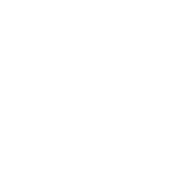

In [123]:
%%time
wordclouds = []
channels = []
counter = 0
# print world cloud for 10 most popular channel
for item in topics.channel.value_counts()[:4].to_dict().items():
    topic_channel, no_of_topic = item
    topic_titles = topics[topics.channel == topic_channel]['title'].values
    topic_titles = [str(topics).split(' ') for topics in topic_titles]
    topic_words = [str(word).lower() for topic in topic_titles for word in topic]
    # create word cloud
    wordcloud = WordCloud(width=200, height=200, background_color='white', stopwords = stopwords, min_font_size=10).generate(" ".join(topic_words))
    wordclouds.append(wordcloud)
    channels.append(topic_channel)
    
# plot word cloud images   
for image, channel in zip(wordclouds, channels):
    plot_index = int(220 + counter + 1)
    plt.subplot(plot_index)
    plt.imshow(wordclouds[counter],plt.axis('off'))
    counter += 1

# show all the image
plt.show()

In [107]:
topics.channel.value_counts()[:10].to_dict().items()

dict_items([('fef095', 5770), ('0ec697', 5355), ('6e90a7', 4554), ('2ee29d', 4438), ('36a98b', 3667), ('000cf7', 2867), ('8e286a', 2780), ('0c929f', 2698), ('c152d6', 2555), ('ef2088', 1684)])

## Correlation data
The content items associated to topics in the training set. A single content item may be associated to more than one topic. In each row, we give a topic_id and a list of all associated content_ids. These comprise the targets of the training set.

In [22]:
# adding count column to calc number of content ids under each topic
correlations['number_of_content_ids'] =  correlations['content_ids'].apply(lambda x : len(x.split(' ')))

In [23]:
%%time
# count occurance for each content id
content_id_counter = Counter()
for content_ids in correlations['content_ids'].values:
    for c in content_ids.split(' '):
        content_id_counter[c] += 1

CPU times: user 44.9 ms, sys: 3.41 ms, total: 48.3 ms
Wall time: 48 ms


In [24]:
correlations.head(3)

,topic_id,content_ids,number_of_content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...,4
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...,4
2,t_00069b63a70a,c_11a1dc0bfb99,1


In [25]:
correlations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61517 entries, 0 to 61516
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   topic_id               61517 non-null  object
 1   content_ids            61517 non-null  object
 2   number_of_content_ids  61517 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


### Correlation highlevel statistic

#### Factors
- Only 61517 unique topic id in the correlation.csv, not all the topic has related content so can use correlation join with other csv file to generate training data
- 154047 unqiue content ids in the correlation.csv, same as content.csv which means all the contents have correlated topics
- Max number of cotent is 293, much higher than the median or average, worth to take look later on
- Most popular content is c_dd739e116435, correlated to 241 topics, worth to take look, it can also treated as popular candidates when making recommendation

In [26]:
%%time
# id
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"Total have {correlations.topic_id.nunique()} unique topic ids, min ID is {sorted(correlations.topic_id.values)[0]}, max ID is {sorted(correlations.topic_id.values)[-1]}")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"No of content id statistic is  {correlations.number_of_content_ids.describe().to_dict()}, no of unique content id is {len(set(content_id_counter.keys()))}")

-------------------------------------------------------------------------------------------------------------------------------------
Total have 61517 unique topic ids, min ID is t_00004da3a1b2, max ID is t_fffe811a6da9
-------------------------------------------------------------------------------------------------------------------------------------
No of content id statistic is  {'count': 61517.0, 'mean': 4.550270656891591, 'std': 6.70025541708405, 'min': 1.0, '25%': 2.0, '50%': 3.0, '75%': 5.0, 'max': 293.0}, no of unique content id is 154047
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 11.4 ms


In [27]:
# print most 10 popular content ids
content_id_counter.most_common(10)

[('c_dd739e116435', 241),
 ('c_2f8849826d71', 75),
 ('c_4f5925b37bdf', 54),
 ('c_59778b25b537', 52),
 ('c_04e6b34426c6', 48),
 ('c_d2b3b43d838a', 44),
 ('c_6d3b0fc13589', 43),
 ('c_3856cf0f321a', 39),
 ('c_76ea3f6f2dca', 36),
 ('c_5a3c3fe31842', 33)]

In [28]:
# take a look at most popular contents - looks like nothing special
top10_content_ids = [d[0] for d in content_id_counter.most_common(10)]
contents[contents['id'].isin(top10_content_ids)]

,id,title,description,kind,text,language,copyright_holder,license,no_of_words_in_title,no_of_words_in_desc
2885,c_04e6b34426c6,Glossary,NaN,html5,----------------------------------------------...,en,CSU and Merlot,CC BY-NC-SA,1,1
28663,c_2f8849826d71,InfoPage,NaN,html5,This open text is disseminated via the Open Ed...,en,CSU and Merlot,CC BY-NC-SA,1,1
33951,c_3856cf0f321a,الدرس الثاني,NaN,video,NaN,ar,NaN,NaN,2,1
47728,c_4f5925b37bdf,Index,NaN,html5,NaN,en,NaN,NaN,1,1
53915,c_59778b25b537,Pasos siguientes,Descubra los pasos siguientes y recursos adici...,html5,Para recibir el certificado que necesita para ...,es,HP LIFE,CC BY,2,50
54375,c_5a3c3fe31842,Student Getting Started Guide,Congratulations! You've got a free textbook. D...,document,Student getting\nstarted guide\nCongratulation...,en,Rice University,CC BY,4,15
65782,c_6d3b0fc13589,Using context clues to figure out new words | ...,"When you're reading, it can be frustrating to ...",video,- [Instructor] Hello readers. You know that fe...,en,Khan Academy,CC BY-NC-SA,10,26
71414,c_76ea3f6f2dca,الدرس الأول,NaN,video,NaN,ar,NaN,NaN,2,1
126834,c_d2b3b43d838a,index.js,NaN,html5,NaN,en,NaN,NaN,1,1
133372,c_dd739e116435,বই,NaN,document,NaN,bn,NaN,NaN,1,1


In [31]:
correlations.loc[correlations['number_of_content_ids'] == correlations['number_of_content_ids'].max()]

,topic_id,content_ids,number_of_content_ids
47249,t_c5673d1b5642,c_004549091742 c_005e9fb8e930 c_019f6e9630d7 c...,293


In [32]:
# take a look at topic has most content
topics.loc[topics['id'] == 't_c5673d1b5642']

,id,title,description,channel,category,level,language,parent,has_content,no_of_words_in_title,no_of_words_in_desc
59116,t_c5673d1b5642,10-13 años,NaN,f41d17,source,2,es,t_caa73c7fb6a8,True,2,1


### Sample submission
 A submission file in the correct format. See the Evaluation page for more details. You must use this file to identify which topics in the test set require predictions.
 - Not too much need to take look at this file, just make sure following the below format should be fine

In [33]:
# This is just a sample submission, in the test enviornment we need to generate it with test data, test data will have new content.csv and topic.csv but correlation.csv will be the same
sample_sub

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_4054df11a74e,c_3695c5dc1df6 c_f2d184a98231


## Content & topics

- merge content and topic by using correlation dataframe, see whether any feature correlation between 2 datasets

In [34]:
%%time
# explode column content_ids -> convert to list -> explode from signle row to multiple rows
correlations['content_id'] = correlations['content_ids'].apply(lambda x : str(x).split(' '))
correlations = correlations.explode('content_id')
correlations = correlations[['topic_id', 'content_id', 'number_of_content_ids']]
correlations.head()

CPU times: user 47.2 ms, sys: 15.7 ms, total: 62.9 ms
Wall time: 81.8 ms


,topic_id,content_id,number_of_content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d,4
0,t_00004da3a1b2,c_376c5a8eb028,4
0,t_00004da3a1b2,c_5bc0e1e2cba0,4
0,t_00004da3a1b2,c_76231f9d0b5e,4
1,t_00068291e9a4,c_639ea2ef9c95,4


In [35]:
%%time
# rename columns before join
topics.columns = ['topic_id', 'topic_title', 'topic_description', 'topic_channel', 'topic_category', 'topic_level', 'topic_language', 'topic_parent', 'topic_has_content', 'topic_no_of_words_in_title', 'topic_no_of_words_in_desc']

# renmae columns before join
contents.columns = ['content_id', 'content_title', 'content_description', 'content_kind', 'content_text', 'content_language', 'content_copyright_holder', 'content_license', 'content_no_of_words_in_title', 'content_no_of_words_in_desc']

# join with topic.csv and content.csv
corr = pd.merge(correlations, topics, on=['topic_id'], how='left')
corr = pd.merge(corr, contents, on=['content_id'], how='left')

# drop uncessary columns
corr.drop(columns=['content_copyright_holder', 'content_license'])

corr.head(3)

CPU times: user 159 ms, sys: 28.5 ms, total: 187 ms
Wall time: 187 ms


,topic_id,content_id,number_of_content_ids,topic_title,topic_description,topic_channel,topic_category,topic_level,topic_language,topic_parent,...,topic_no_of_words_in_desc,content_title,content_description,content_kind,content_text,content_language,content_copyright_holder,content_license,content_no_of_words_in_title,content_no_of_words_in_desc
0,t_00004da3a1b2,c_1108dd0c7a5d,4,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,...,17,Молив като резистор,"Моливът причинява промяна в отклонението, подо...",video,NaN,bg,NaN,NaN,3,12
1,t_00004da3a1b2,c_376c5a8eb028,4,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,...,17,Да чуем променливото съпротивление,Тук чертаем линия на лист хартия и я използвам...,video,NaN,bg,NaN,NaN,4,22
2,t_00004da3a1b2,c_5bc0e1e2cba0,4,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,...,17,Променлив резистор (реостат) с графит от молив,Използваме сърцевината на молива (неговия граф...,video,NaN,bg,NaN,NaN,7,23


### check whether paired topic and content have the same language

#### Factor
- over 99% pairs have the same language, so language could be hard rule or a feature in your model
- most different language pair have English which is also make sense since this is most popular language in the world

In [36]:
%%time
# check whether topic and content have the same language
print(f"Number of {len(corr.loc[corr['topic_language'] == corr['content_language']])} pairs have same language ")
print(f"Number of {len(corr.loc[corr['topic_language'] != corr['content_language']])} pairs have different language ")

Number of 278833 pairs have same language 
Number of 1086 pairs have different language 
CPU times: user 77.4 ms, sys: 24.3 ms, total: 102 ms
Wall time: 101 ms


In [37]:
# display correlation have different language pair
corr.loc[corr['topic_language'] != corr['content_language']][['topic_language', 'content_language']].drop_duplicates()

,topic_language,content_language
918,es,en
1063,en,zh
2736,ar,en
3933,en,ar
3934,en,pt
6961,hi,en
12931,en,kn
16225,en,es
38768,en,hi
42788,en,ur


### Check whether any word overlap between topic and content

#### Factor
- There are not too much word overlap between paired topic and content hence for most of data we need to rely on language model
- But there do have some exceptions, we can some topic and content overlapped is 24 words in topic and 288 words in desc - so maybe a rule can be setup before modeling -> if any overlap words > 50% treat this content should under this topic

In [38]:
def word_overlap(r):
    
    topic_title = str(r['topic_title']).split(' ')
    topic_description = str(r['topic_description']).split(' ')
    content_title = str(r['content_title']).split(' ')
    content_description = str(r['content_description']).split(' ')
    
    topic_overlap = set(topic_title).intersection(set(content_title))
    desc_overlap = set(topic_description).intersection(set(content_description))
    
    return [list(topic_overlap), len(topic_overlap), list(desc_overlap), len(desc_overlap)]
    

In [39]:
%%time
world_overlap = corr.apply(lambda row : word_overlap(row), axis=1, result_type='expand').reset_index().drop(columns=['index'])
world_overlap.columns = ['title_overlap_words', 'no_of_title_overlapped', 'desc_overlap_words', 'no_of_content_overlapped']
world_overlap

CPU times: user 4.28 s, sys: 46.8 ms, total: 4.32 s
Wall time: 4.32 s


,title_overlap_words,no_of_title_overlapped,desc_overlap_words,no_of_content_overlapped
0,[],0,"[в, отклонението,, на]",3
1,[],0,"[с, на]",2
2,[],0,[на],1
3,[на],1,"[когато, на, се]",3
4,"[de, e]",2,[],0
...,...,...,...,...
279914,"[El, periódico]",2,[nan],1
279915,[],0,[inscribed],1
279916,[],0,[of],1
279917,[],0,[nan],1


In [40]:
world_overlap.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_title_overlapped,279919.0,1.135579,1.708434,0.0,0.0,0.0,2.0,24.0
no_of_content_overlapped,279919.0,1.564678,5.126405,0.0,0.0,1.0,2.0,288.0
